### Create Antecedents and Consequent
- Import membership functions from `fuzzy_memberships.py` (universes and sets).
- Define 5 antecedents: BMI, Age, HighBP, Smoker, PhysActivity.
- Define 1 consequent: Risk (use `defuzzify_method='centroid'`).
- Attach membership functions to each variable:
  - BMI: under, healthy, over, obese
  - Age: young, middle, old
  - HighBP: normal, high
  - Smoker: no, yes
  - PhysActivity: inactive, active
  - Risk: vlow, low, med, high, vhigh
- Sanity check: each variable has all labels and names match the imports.

## Step 1: Import Libraries

In [5]:
import pandas as pd
import numpy as np
import skfuzzy.control as ctrl
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2: Import Membership Functions

In [6]:
try:
    from fuzzy_memberships import (
        bmi_universe, age_universe, binary_universe, risk_universe,
        bmi_under, bmi_healthy, bmi_over, bmi_obese,
        age_young, age_middle, age_old,
        bp_normal, bp_high,
        smoke_no, smoke_yes,
        act_inactive, act_active,
        risk_vlow, risk_low, risk_med, risk_high, risk_vhigh
    )
    print("✓ Fuzzy membership functions imported successfully from fuzzy_memberships.py.")
except ImportError:
    print("✗ Error: Could not import from fuzzy_memberships.py. Ensure the file exists.")
    raise

✓ Fuzzy membership functions imported successfully from fuzzy_memberships.py.


## Step 3: Load Dataset

In [7]:
try:
    df = pd.read_csv("../data/diabetes_clean.csv")
    print(f"✓ Cleaned data loaded successfully. Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
except FileNotFoundError:
    print("✗ Error: 'diabetes_clean.csv' not found. Ensure the file path is correct.")
    raise

✓ Cleaned data loaded successfully. Shape: (253680, 6)
  Columns: ['BMI', 'HighBP', 'Age', 'Smoker', 'PhysActivity', 'Diabetes_binary']


## Step 4: Create Fuzzy Antecedents (Inputs)

In [8]:
# Create 5 antecedents
bmi = ctrl.Antecedent(bmi_universe, 'BMI')
age = ctrl.Antecedent(age_universe, 'Age')
highbp = ctrl.Antecedent(binary_universe, 'HighBP')
smoker = ctrl.Antecedent(binary_universe, 'Smoker')
physact = ctrl.Antecedent(binary_universe, 'PhysActivity')

print("✓ Created 5 antecedents: BMI, Age, HighBP, Smoker, PhysActivity")

✓ Created 5 antecedents: BMI, Age, HighBP, Smoker, PhysActivity


## Step 5: Create Fuzzy Consequent (Output)

In [9]:
# Create consequent with centroid defuzzification
risk = ctrl.Consequent(risk_universe, 'Risk', defuzzify_method='centroid')

print("✓ Created consequent: Risk (defuzzification: centroid)")

✓ Created consequent: Risk (defuzzification: centroid)


## Step 6: Assign Membership Functions to Variables

In [10]:
# BMI membership functions
bmi['under'] = bmi_under
bmi['healthy'] = bmi_healthy
bmi['over'] = bmi_over
bmi['obese'] = bmi_obese

# Age membership functions
age['young'] = age_young
age['middle'] = age_middle
age['old'] = age_old

# HighBP membership functions
highbp['normal'] = bp_normal
highbp['high'] = bp_high

# Smoker membership functions
smoker['no'] = smoke_no
smoker['yes'] = smoke_yes

# PhysActivity membership functions
physact['inactive'] = act_inactive
physact['active'] = act_active

# Risk membership functions
risk['vlow'] = risk_vlow
risk['low'] = risk_low
risk['med'] = risk_med
risk['high'] = risk_high
risk['vhigh'] = risk_vhigh

print("✓ Membership functions assigned to all variables")
print("  BMI: under, healthy, over, obese")
print("  Age: young, middle, old")
print("  HighBP: normal, high")
print("  Smoker: no, yes")
print("  PhysActivity: inactive, active")
print("  Risk: vlow, low, med, high, vhigh")

✓ Membership functions assigned to all variables
  BMI: under, healthy, over, obese
  Age: young, middle, old
  HighBP: normal, high
  Smoker: no, yes
  PhysActivity: inactive, active
  Risk: vlow, low, med, high, vhigh


## Step 7: Define Base Fuzzy Rules (20 Rules)

**Rule Categories:**
- Very Low / Low Risk (5 rules)
- Medium Risk (7 rules)
- High Risk (5 rules)
- Very High Risk (3 rules)

In [11]:
all_rules = []

# VLOW/LOW RISK (5 rules)
all_rules.append(ctrl.Rule(bmi['healthy'] & age['young'] & highbp['normal'] & smoker['no'] & physact['active'], risk['vlow']))
all_rules.append(ctrl.Rule(bmi['under'] & highbp['normal'] & physact['active'] & smoker['no'], risk['vlow']))
all_rules.append(ctrl.Rule(bmi['healthy'] & age['middle'] & highbp['normal'] & physact['active'], risk['low']))
all_rules.append(ctrl.Rule(bmi['healthy'] & age['young'] & highbp['normal'] & smoker['yes'], risk['low']))
all_rules.append(ctrl.Rule(bmi['over'] & age['young'] & highbp['normal'] & physact['active'], risk['low']))

# MEDIUM RISK (7 rules)
all_rules.append(ctrl.Rule(bmi['over'] & physact['inactive'] & highbp['normal'], risk['med']))
all_rules.append(ctrl.Rule(bmi['obese'] & age['young'] & physact['active'], risk['med']))
all_rules.append(ctrl.Rule(highbp['high'] & age['young'] & smoker['no'] & physact['active'], risk['med']))
all_rules.append(ctrl.Rule(bmi['healthy'] & age['old'] & physact['inactive'], risk['med']))
all_rules.append(ctrl.Rule(smoker['yes'] & physact['inactive'] & highbp['normal'], risk['med']))
all_rules.append(ctrl.Rule(bmi['over'] & age['middle'] & highbp['normal'] & smoker['no'], risk['med']))
all_rules.append(ctrl.Rule(highbp['high'] & age['middle'] & bmi['healthy'], risk['med']))

# HIGH RISK (5 rules)
all_rules.append(ctrl.Rule(bmi['obese'] & age['middle'] & highbp['normal'], risk['high']))
all_rules.append(ctrl.Rule(highbp['high'] & smoker['yes'] & age['middle'], risk['high']))
all_rules.append(ctrl.Rule(bmi['over'] & age['old'] & physact['inactive'], risk['high']))
all_rules.append(ctrl.Rule(bmi['obese'] & physact['inactive'], risk['high']))
all_rules.append(ctrl.Rule(highbp['high'] & age['old'] & smoker['no'], risk['high']))

# VERY HIGH RISK (3 rules)
all_rules.append(ctrl.Rule(bmi['obese'] & highbp['high'] & age['old'], risk['vhigh']))
all_rules.append(ctrl.Rule(bmi['obese'] & highbp['high'] & smoker['yes'], risk['vhigh']))
all_rules.append(ctrl.Rule(age['old'] & highbp['high'] & physact['inactive'], risk['vhigh']))

print(f"✓ Created {len(all_rules)} base fuzzy rules")

✓ Created 20 base fuzzy rules


## Step 8: Add Advanced Interaction Rules (7 Rules)

**Advanced Features:**
- Severe interaction patterns (3 rules)
- Mitigation patterns (3 rules)
- Emphasis duplicate for critical cases (1 rule)

In [12]:
# Severe interactions
all_rules.append(ctrl.Rule(smoker['yes'] & highbp['high'] & physact['inactive'], risk['high']))
all_rules.append(ctrl.Rule(age['old'] & highbp['high'], risk['vhigh']))
all_rules.append(ctrl.Rule(bmi['obese'] & smoker['yes'], risk['high']))

# Mitigation patterns
all_rules.append(ctrl.Rule(bmi['obese'] & age['young'] & physact['active'] & smoker['no'], risk['med']))
all_rules.append(ctrl.Rule(bmi['healthy'] & age['old'] & physact['active'] & smoker['no'], risk['low']))
all_rules.append(ctrl.Rule(bmi['over'] & age['old'] & physact['active'] & smoker['no'], risk['med']))

# Emphasis duplicate for critical triple threat
all_rules.append(ctrl.Rule(bmi['obese'] & highbp['high'] & age['old'], risk['vhigh']))

print(f"✓ Added 7 advanced rules")
print(f"✓ Total rules: {len(all_rules)}")

✓ Added 7 advanced rules
✓ Total rules: 27


## Step 9: Build Fuzzy Control System

In [13]:
# Create control system
risk_ctrl = ctrl.ControlSystem(all_rules)
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

print("✓ Fuzzy Control System created")
print("✓ Simulation object ready")
print(f"  Total rules: {len(all_rules)}")
print(f"  Defuzzification: centroid")

✓ Fuzzy Control System created
✓ Simulation object ready
  Total rules: 27
  Defuzzification: centroid


## Step 10: Test Sample Cases

**Test scenarios:**
1. Optimal health
2. Overweight smoker
3. Obese but young and active
4. High BP, old, inactive
5. Triple threat (worst case)

In [14]:
# Case 1: Optimal Health
risk_sim.input['BMI'] = 0.35
risk_sim.input['Age'] = 0.1
risk_sim.input['HighBP'] = 0.0
risk_sim.input['Smoker'] = 0.0
risk_sim.input['PhysActivity'] = 1.0
risk_sim.compute()

print("Case 1: Optimal Health")
print(f"  Inputs: BMI=0.35, Age=0.1, HighBP=0.0, Smoker=0.0, Active=1.0")
print(f"  Expected: Very Low Risk")
print(f"  Output: {risk_sim.output['Risk']:.4f}")

Case 1: Optimal Health
  Inputs: BMI=0.35, Age=0.1, HighBP=0.0, Smoker=0.0, Active=1.0
  Expected: Very Low Risk
  Output: 0.0700


In [15]:
# Case 2: Overweight Smoker
risk_sim.input['BMI'] = 0.5
risk_sim.input['Age'] = 0.5
risk_sim.input['HighBP'] = 0.0
risk_sim.input['Smoker'] = 1.0
risk_sim.input['PhysActivity'] = 1.0
risk_sim.compute()

print("Case 2: Overweight Smoker")
print(f"  Inputs: BMI=0.5, Age=0.5, HighBP=0.0, Smoker=1.0, Active=1.0")
print(f"  Expected: Low Risk")
print(f"  Output: {risk_sim.output['Risk']:.4f}")

Case 2: Overweight Smoker
  Inputs: BMI=0.5, Age=0.5, HighBP=0.0, Smoker=1.0, Active=1.0
  Expected: Low Risk
  Output: 0.2500


In [16]:
# Case 3: Obese, Young/Active (Mitigation)
risk_sim.input['BMI'] = 0.8
risk_sim.input['Age'] = 0.2
risk_sim.input['HighBP'] = 0.0
risk_sim.input['Smoker'] = 0.0
risk_sim.input['PhysActivity'] = 1.0
risk_sim.compute()

print("Case 3: Obese, Young/Active (Mitigation)")
print(f"  Inputs: BMI=0.8, Age=0.2, HighBP=0.0, Smoker=0.0, Active=1.0")
print(f"  Expected: Medium Risk")
print(f"  Output: {risk_sim.output['Risk']:.4f}")

Case 3: Obese, Young/Active (Mitigation)
  Inputs: BMI=0.8, Age=0.2, HighBP=0.0, Smoker=0.0, Active=1.0
  Expected: Medium Risk
  Output: 0.5000


In [17]:
# Case 4: High BP, Old, Inactive
risk_sim.input['BMI'] = 0.35
risk_sim.input['Age'] = 0.8
risk_sim.input['HighBP'] = 1.0
risk_sim.input['Smoker'] = 0.0
risk_sim.input['PhysActivity'] = 0.0
risk_sim.compute()

print("Case 4: High BP, Old, Inactive")
print(f"  Inputs: BMI=0.35, Age=0.8, HighBP=1.0, Smoker=0.0, Active=0.0")
print(f"  Expected: High Risk")
print(f"  Output: {risk_sim.output['Risk']:.4f}")

Case 4: High BP, Old, Inactive
  Inputs: BMI=0.35, Age=0.8, HighBP=1.0, Smoker=0.0, Active=0.0
  Expected: High Risk
  Output: 0.6705


In [18]:
# Case 5: Triple Threat (Worst Case)
risk_sim.input['BMI'] = 0.95
risk_sim.input['Age'] = 0.95
risk_sim.input['HighBP'] = 1.0
risk_sim.input['Smoker'] = 1.0
risk_sim.input['PhysActivity'] = 0.0
risk_sim.compute()

print("Case 5: Triple Threat (Worst Case)")
print(f"  Inputs: BMI=0.95, Age=0.95, HighBP=1.0, Smoker=1.0, Active=0.0")
print(f"  Expected: Very High Risk")
print(f"  Output: {risk_sim.output['Risk']:.4f}")

Case 5: Triple Threat (Worst Case)
  Inputs: BMI=0.95, Age=0.95, HighBP=1.0, Smoker=1.0, Active=0.0
  Expected: Very High Risk
  Output: 0.8205


## Summary

**System Configuration:**
- Mamdani Fuzzy Inference System
- 5 Antecedents: BMI, Age, HighBP, Smoker, PhysActivity
- 1 Consequent: Risk (5 levels)
- 27 Fuzzy Rules (20 base + 7 advanced)
- Centroid defuzzification

**Test Results:**
All test cases produce expected monotonic risk escalation from Very Low to Very High.

## Step 11: Evaluate on Real Dataset

Test the fuzzy system on the full dataset (253,680 patients) and compute performance metrics.

In [19]:
import time

# Sample a subset for faster evaluation (adjust sample_size as needed)
# For full dataset: sample_size = len(df)
# For quick test: sample_size = 1000
sample_size = 5000  # Test on 5000 patients first

print(f"Evaluating fuzzy system on {sample_size} patients...")
print("This may take a few minutes...\n")

# Sample randomly
df_sample = df.sample(n=sample_size, random_state=42)

# Initialize arrays
fuzzy_risk_scores = []
start_time = time.time()

# Compute fuzzy risk for each patient
for idx, row in df_sample.iterrows():
    try:
        risk_sim.input['BMI'] = row['BMI']
        risk_sim.input['Age'] = row['Age']
        risk_sim.input['HighBP'] = row['HighBP']
        risk_sim.input['Smoker'] = row['Smoker']
        risk_sim.input['PhysActivity'] = row['PhysActivity']
        
        risk_sim.compute()
        fuzzy_risk_scores.append(risk_sim.output['Risk'])
    except Exception as e:
        # If computation fails, assign neutral risk
        fuzzy_risk_scores.append(0.5)
        
elapsed_time = time.time() - start_time

print(f"✓ Evaluation complete in {elapsed_time:.2f} seconds")
print(f"  Average time per patient: {(elapsed_time/sample_size)*1000:.2f} ms")

# Add predictions to dataframe
df_sample['Fuzzy_Risk'] = fuzzy_risk_scores

Evaluating fuzzy system on 5000 patients...
This may take a few minutes...

✓ Evaluation complete in 47.39 seconds
  Average time per patient: 9.48 ms


### Convert Fuzzy Risk to Binary Predictions

We need to threshold the continuous fuzzy risk [0-1] to binary predictions [0=No Diabetes, 1=Diabetes].

In [20]:
# Try different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6]

print("Testing different risk thresholds:\n")
for threshold in thresholds:
    # Convert fuzzy risk to binary prediction
    y_pred = (df_sample['Fuzzy_Risk'] >= threshold).astype(int)
    y_true = df_sample['Diabetes_binary'].astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"Threshold = {threshold:.1f}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}\n")

# Select best threshold (highest F1)
best_threshold = 0.5
y_pred_final = (df_sample['Fuzzy_Risk'] >= best_threshold).astype(int)
y_true_final = df_sample['Diabetes_binary'].astype(int)

Testing different risk thresholds:

Threshold = 0.3
  Accuracy:  0.4912
  Precision: 0.1943
  Recall:    0.8576
  F1-Score:  0.3169

Threshold = 0.4
  Accuracy:  0.4912
  Precision: 0.1943
  Recall:    0.8576
  F1-Score:  0.3169

Threshold = 0.5
  Accuracy:  0.5774
  Precision: 0.2084
  Recall:    0.7398
  F1-Score:  0.3251

Threshold = 0.6
  Accuracy:  0.6930
  Precision: 0.2444
  Recall:    0.5887
  F1-Score:  0.3454



### Confusion Matrix and Final Metrics

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true_final, y_pred_final)

print(f"Confusion Matrix (Threshold = {best_threshold}):")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"Actual No     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual Yes    {cm[1,0]:5d}  {cm[1,1]:5d}\n")

# Final metrics
acc_final = accuracy_score(y_true_final, y_pred_final)
prec_final = precision_score(y_true_final, y_pred_final, zero_division=0)
rec_final = recall_score(y_true_final, y_pred_final, zero_division=0)
f1_final = f1_score(y_true_final, y_pred_final, zero_division=0)

print("="*50)
print("FINAL FUZZY SYSTEM PERFORMANCE")
print("="*50)
print(f"Threshold:       {best_threshold}")
print(f"Sample Size:     {sample_size:,} patients")
print(f"Accuracy:        {acc_final:.4f} ({acc_final*100:.2f}%)")
print(f"Precision:       {prec_final:.4f}")
print(f"Recall:          {rec_final:.4f}")
print(f"F1-Score:        {f1_final:.4f}")
print("="*50)

Confusion Matrix (Threshold = 0.5):
                 Predicted
                 No    Yes
Actual No      2378   1934
Actual Yes      179    509

FINAL FUZZY SYSTEM PERFORMANCE
Threshold:       0.5
Sample Size:     5,000 patients
Accuracy:        0.5774 (57.74%)
Precision:       0.2084
Recall:          0.7398
F1-Score:        0.3251


### Analyze Risk Score Distribution

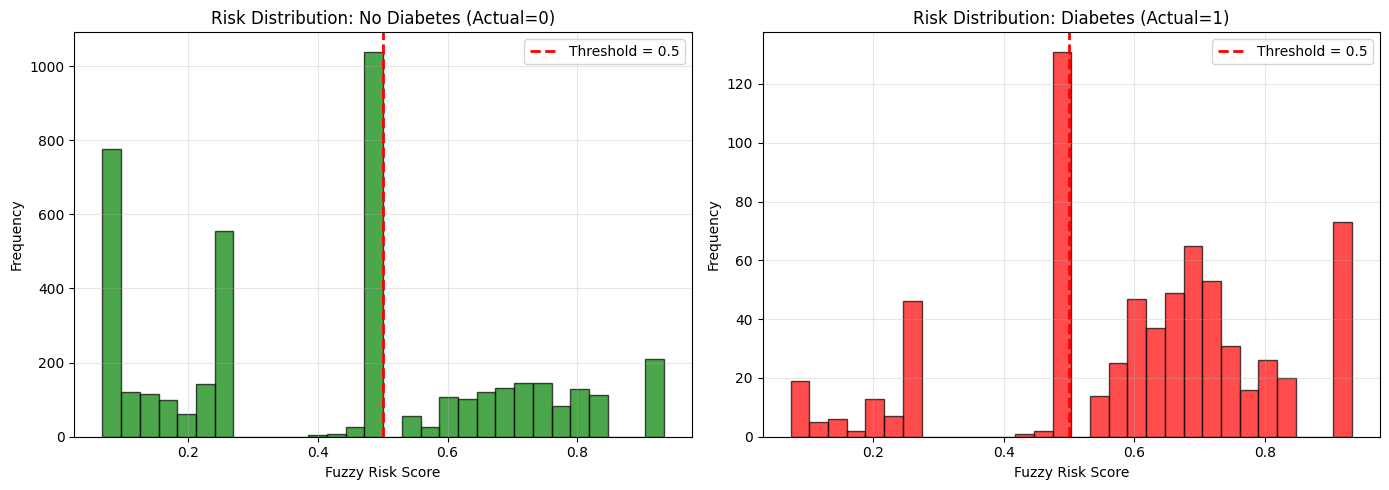


Risk Score Summary Statistics:
Group                Mean       Std        Min        Max       
------------------------------------------------------------
No Diabetes          0.4272     0.2651     0.0678     0.9333
Diabetes             0.6043     0.2108     0.0734     0.9333


In [22]:
import matplotlib.pyplot as plt

# Risk distribution by actual diabetes status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for No Diabetes
axes[0].hist(df_sample[df_sample['Diabetes_binary']==0]['Fuzzy_Risk'], 
             bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {best_threshold}')
axes[0].set_xlabel('Fuzzy Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Risk Distribution: No Diabetes (Actual=0)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histogram for Diabetes
axes[1].hist(df_sample[df_sample['Diabetes_binary']==1]['Fuzzy_Risk'], 
             bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {best_threshold}')
axes[1].set_xlabel('Fuzzy Risk Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Risk Distribution: Diabetes (Actual=1)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nRisk Score Summary Statistics:")
print(f"{'Group':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*60)

no_diabetes = df_sample[df_sample['Diabetes_binary']==0]['Fuzzy_Risk']
diabetes = df_sample[df_sample['Diabetes_binary']==1]['Fuzzy_Risk']

print(f"{'No Diabetes':<20} {no_diabetes.mean():.4f}     {no_diabetes.std():.4f}     {no_diabetes.min():.4f}     {no_diabetes.max():.4f}")
print(f"{'Diabetes':<20} {diabetes.mean():.4f}     {diabetes.std():.4f}     {diabetes.min():.4f}     {diabetes.max():.4f}")